[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total samples: 44898
label
FAKE    23481
REAL    21417
Name: count, dtype: int64
Label classes: ['FAKE' 'REAL']

=== Training Logistic Regression ===
Test Accuracy: 0.9891
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      4696
        REAL       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



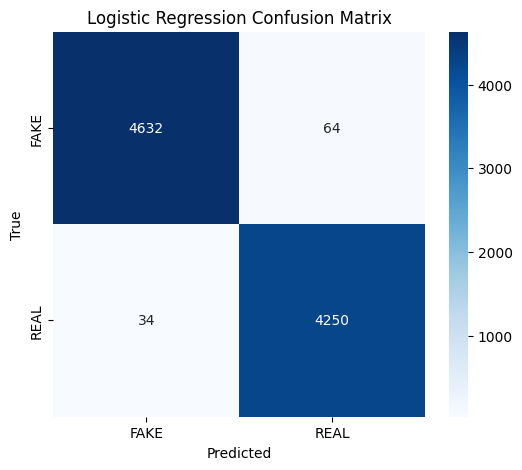

Saved Logistic Regression model as logistic_regression_model.pkl

=== Training Linear SVM ===
Test Accuracy: 0.9947
              precision    recall  f1-score   support

        FAKE       1.00      0.99      0.99      4696
        REAL       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



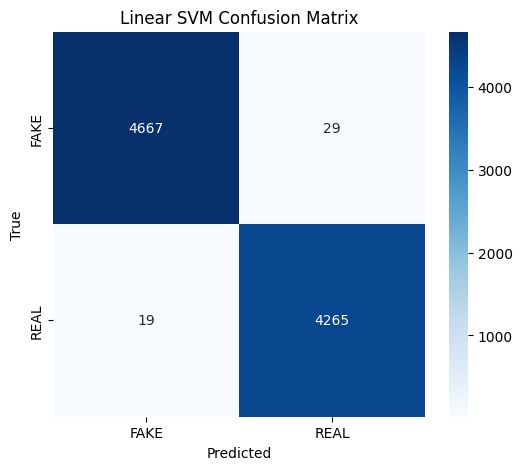

Saved Linear SVM model as linear_svm_model.pkl

=== Training Multinomial Naive Bayes ===
Test Accuracy: 0.9356
              precision    recall  f1-score   support

        FAKE       0.94      0.93      0.94      4696
        REAL       0.93      0.94      0.93      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



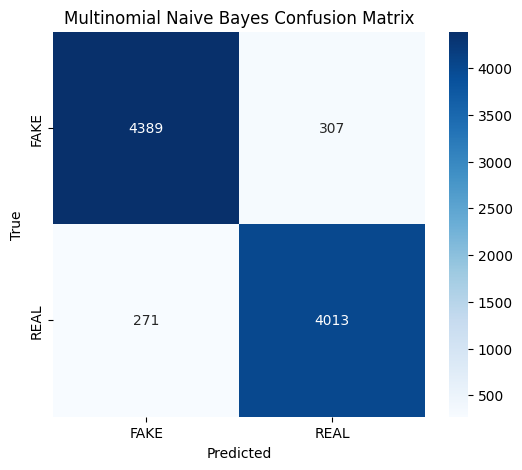

Saved Multinomial Naive Bayes model as multinomial_naive_bayes_model.pkl


In [7]:
# ==============================
# Fake News and Misinformation Detector - LIAR Dataset
# ==============================

# 1. Install required libraries (uncomment if running in Colab)
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk

# 2. Import Libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# ==============================
# 3. Load CSV files
# ==============================
true_df = pd.read_csv("/content/drive/MyDrive/Fake_News_Detection/Kaggle_dataset/True.csv")
fake_df = pd.read_csv("/content/drive/MyDrive/Fake_News_Detection/Kaggle_dataset/Fake.csv")

true_df['label'] = 'REAL'
fake_df['label'] = 'FAKE'

# Combine
df = pd.concat([true_df, fake_df], ignore_index=True)
print("Total samples:", len(df))
print(df['label'].value_counts())

# ==============================
# 4. Preprocessing
# ==============================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)

# ==============================
# 5. Encode Labels
# ==============================
label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['label'])
print("Label classes:", label_encoder.classes_)  # ['FAKE', 'REAL']

# ==============================
# 6. Train/Test Split
# ==============================
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_enc'])

# ==============================
# 7. Define Models
# ==============================
models = {
    "Logistic Regression": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, stop_words='english')),
        ("clf", LogisticRegression(max_iter=200, solver="liblinear"))
    ]),
    "Linear SVM": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, stop_words='english')),
        ("clf", LinearSVC())
    ]),
    "Multinomial Naive Bayes": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, stop_words='english')),
        ("clf", MultinomialNB())
    ])
}

# ==============================
# 8. Train, Evaluate, and Save Models
# ==============================
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(train_df['clean_text'], train_df['label_enc'])

    # Evaluate
    test_preds = model.predict(test_df['clean_text'])
    acc = accuracy_score(test_df['label_enc'], test_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(test_df['label_enc'], test_preds, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label_enc'], test_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Save model
    filename = name.lower().replace(" ", "_") + "_model.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved {name} model as {filename}")
